In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

from shapely.geometry import mapping, Point, Polygon, MultiPolygon
from shapely.ops import unary_union

import matplotlib.pyplot as plt

In [3]:
df = gpd.read_file('dataset/archive/deforestation_labels.geojson')
df

,img_date,tile,geometry
0,2016-04-09,36UXA,"POLYGON ((35.7913 50.17406, 35.79277 50.17354,..."
1,2016-04-09,36UXA,"POLYGON ((35.77653 50.10271, 35.7781 50.10318,..."
2,2016-04-09,36UXA,"POLYGON ((35.78621 50.01277, 35.78616 50.01369..."
3,2016-04-09,36UXA,"POLYGON ((35.78007 50.00556, 35.78189 50.00557..."
4,2016-04-09,36UXA,"POLYGON ((35.79781 49.99568, 35.79908 49.99582..."
...,...,...,...
5691,2019-09-09,36UYA,"POLYGON ((36.37494 50.17378, 36.37506 50.17376..."
5692,2019-09-09,36UYA,"POLYGON ((36.37849 50.17354, 36.37851 50.17352..."
5693,2019-09-09,36UYA,"POLYGON ((35.91477 50.22407, 35.91472 50.22394..."
5694,2019-10-26,36UYA,"POLYGON ((36.88312 50.26589, 36.88408 50.26489..."


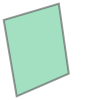

In [5]:
df['geometry'][1]

In [6]:
RASTER_PATH = 'dataset/archive/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_TCI.jp2'

with rasterio.open(RASTER_PATH, "r", driver='JP2OpenJPEG') as src:
    raster_image = src.read()
    raster_meta = src.meta

In [7]:
raster_image.shape

(3, 10980, 10980)

In [8]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(10.0, 0.0, 699960.0,
        0.0, -10.0, 5600040.0)}

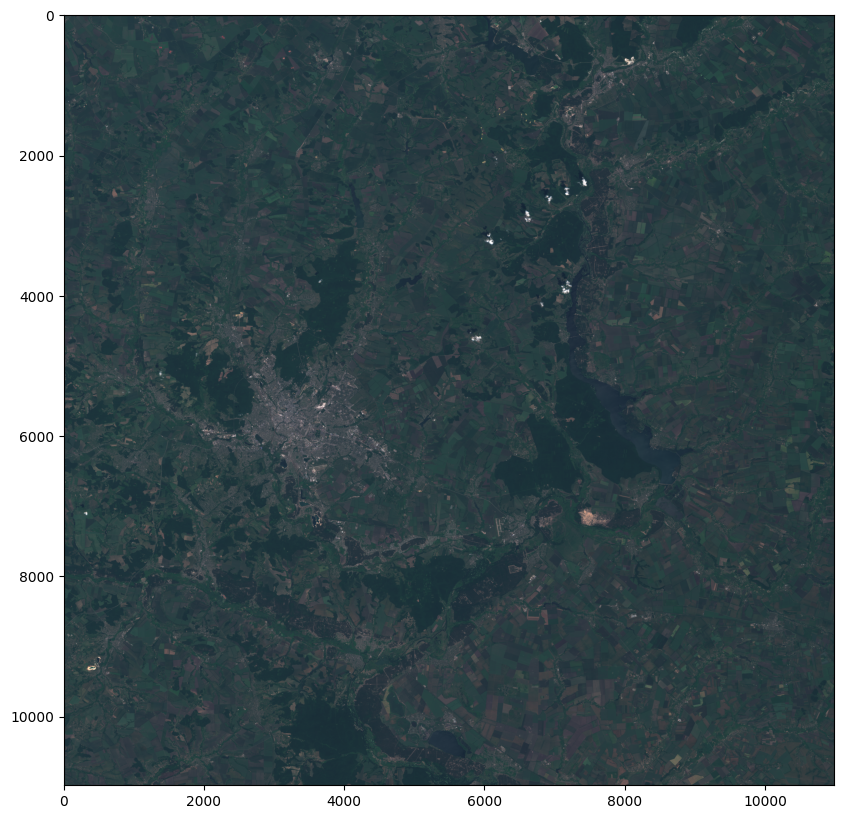

In [9]:
raster_img = reshape_as_image(raster_image)
plt.figure(figsize=(10, 10))
plt.imshow(raster_img)

In [10]:
# assigning crs
# use 4236 for tiles from this dataset
df.crs = {'init':'epsg:4236'}

#transforming polygons to the raster crs
df = df.to_crs({'init' : raster_meta['crs']['init']})
df

F:\Work\python\DataScienceInternship\.venv\Lib\site-packages\pyproj\crs\crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,img_date,tile,geometry
0,2016-04-09,36UXA,"POLYGON ((699218.537 5562133.702, 699325.839 5..."
1,2016-04-09,36UXA,"POLYGON ((698459.426 5554162.662, 698569.358 5..."
2,2016-04-09,36UXA,"POLYGON ((699524.788 5544189.095, 699516.903 5..."
3,2016-04-09,36UXA,"POLYGON ((699114.519 5543371.364, 699244.558 5..."
4,2016-04-09,36UXA,"POLYGON ((700426.849 5542320.373, 700517.265 5..."
...,...,...,...
5691,2019-09-09,36UYA,"POLYGON ((740891.051 5563826.491, 740899.346 5..."
5692,2019-09-09,36UYA,"POLYGON ((741145.387 5563811.991, 741147.24 55..."
5693,2019-09-09,36UYA,"POLYGON ((707816.789 5568031.074, 707813.722 5..."
5694,2019-10-26,36UYA,"POLYGON ((776636.52 5575832.368, 776710.566 55..."


In [24]:
from shapely.ops import cascaded_union


# rasterize works with polygons that are in image coordinate system
def poly_from_utm(polygon, transform):
    # make a polygon from multipolygon
    if isinstance(polygon, Polygon):
        poly = polygon  # уже Polygon
    elif isinstance(polygon, MultiPolygon):
        poly = cascaded_union(polygon)
    # transfrom each polygon to image crs, using raster meta
    poly_pts = [~transform * (x, y) for x, y, *rest in poly.exterior.coords]
    return Polygon(poly_pts)

# creating binary mask
poly_shp = []
im_size = (src.meta['height'], src.meta['width'])
for num, row in df.iterrows():
    if row['geometry'].geom_type == 'Polygon':
        poly_shp.append(poly_from_utm(row['geometry'], src.meta['transform']))
    else:
        for p in row['geometry'].geoms:
            poly_shp.append(poly_from_utm(p, src.meta['transform']))

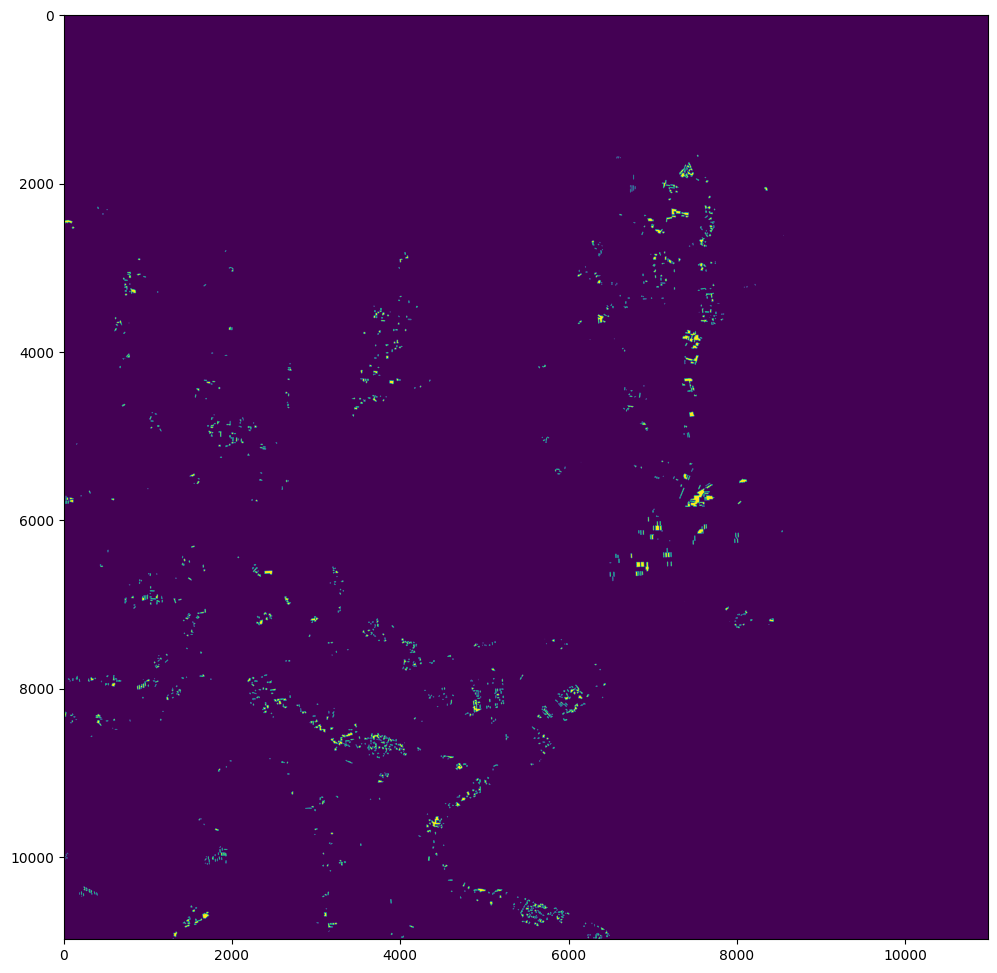

In [25]:
mask = rasterize(shapes=poly_shp, out_shape=im_size)
plt.figure(figsize=(12,12))
plt.imshow(mask)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])